In [1]:
___Author___='LumberJack Jyss'

In [2]:
print('Global Optimized LumberJack Equities Method\n°OoO_FOREX_Oo0°\nLumberJack Jyss 5779(c)')

Global Optimized LumberJack Equities Method
°OoO_FOREX_Oo0°
LumberJack Jyss 5779(c)


In [3]:
print('Importing librairies...')
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,roc_curve,confusion_matrix,classification_report,cohen_kappa_score
from keras.layers import GaussianNoise
from keras.models import Sequential
from keras.layers import Input
from keras.layers import Dense,Dropout
from keras.optimizers import SGD
from keras.utils import to_categorical
%matplotlib inline
print('Librairies imported')

Importing librairies...


Using TensorFlow backend.


Librairies imported


In [37]:
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")
tf.logging.set_verbosity(tf.logging.ERROR)

In [61]:
df_15min = pd.read_csv('20190526 data prepared.csv')
df_15min = df_15min.iloc[:,1:]
df_15min = df_15min.dropna()
df_15min.reset_index(inplace=True,drop=True)

In [62]:
df_15min.isnull().sum().sum()

0

In [63]:
df_15min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6441 entries, 0 to 6440
Data columns (total 27 columns):
Date                  6441 non-null object
Vix                   6441 non-null float64
Varop_Spy             6441 non-null float64
Varhl_spy             6441 non-null float64
Varop_vix             6441 non-null float64
Varhl_vix             6441 non-null float64
RSI                   6441 non-null float64
75 - RSI              6441 non-null float64
RSI - 25              6441 non-null float64
BBD_Delta_Up          6441 non-null float64
delta5_8              6441 non-null float64
delta8_10             6441 non-null float64
delta10_12            6441 non-null float64
delta12_15            6441 non-null float64
delta15_30            6441 non-null float64
delta30_35            6441 non-null float64
delta35_40            6441 non-null float64
delta40_45            6441 non-null float64
delta45_50            6441 non-null float64
Spread                6441 non-null float64
Peaks         

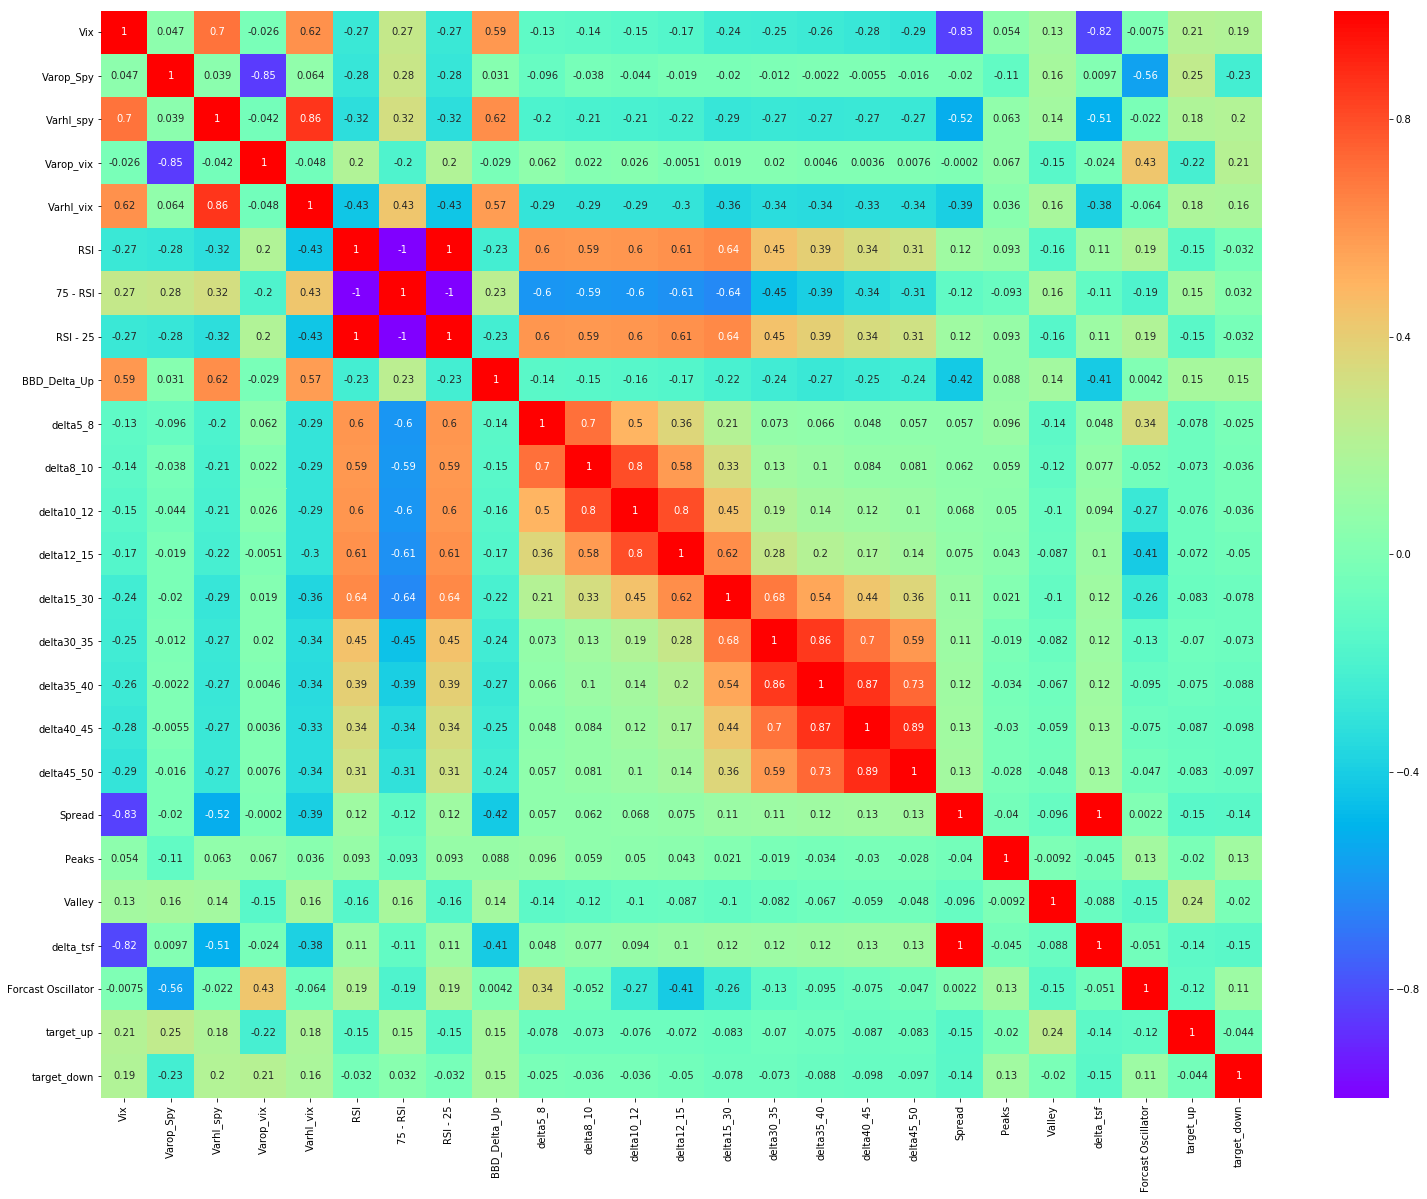

In [64]:
plt.figure(figsize=(26,20))
sns.heatmap(df_15min.iloc[:,:-1].corr(),annot=True,cmap='rainbow')
plt.show()

In [65]:
df_15min.shape

(6441, 27)

In [66]:
df_15min['target_up'].sum(),df_15min['target_down'].sum()

(278, 263)

In [67]:
#df_15min = df_15min.iloc[-2500:,:]
#df_15min['target_up'].sum(),df_15min['target_down'].sum()

(72, 67)

In [68]:
delta = round(df_15min.shape[0])
bloc1 = round(delta*0.9)
bloc2 = delta - bloc1
print("# of periods : ",delta)
print('On 80% - 20% slash : ')
print('Bloc 1 : ',bloc1,' periods (',df_15min.iloc[bloc1,0],')\nBloc 2 :',bloc2,' periods (',df_15min.iloc[bloc2,0],')')
print('First period :',df_15min.iloc[0,0])
print('Last period :',df_15min.iloc[df_15min.shape[0]-1,0])


# of periods :  2500
On 80% - 20% slash : 
Bloc 1 :  2250  periods ( 20190517  18:00:00 )
Bloc 2 : 250  periods ( 20190128  18:30:00 )
First period : 20190111  21:00:00
Last period : 20190531  21:45:00


In [69]:
df_15min.head(0)

Empty DataFrame
Columns: [Date, Vix, Varop_Spy, Varhl_spy, Varop_vix, Varhl_vix, RSI, 75 - RSI, RSI - 25, BBD_Delta_Up, delta5_8, delta8_10, delta10_12, delta12_15, delta15_30, delta30_35, delta35_40, delta40_45, delta45_50, Spread, Peaks, Valley, delta_tsf, Forcast Oscillator, target_up, target_down, target_value]
Index: []

[0 rows x 27 columns]

In [70]:
X = df_15min.iloc[:,1:-4]
X = X.drop(['Peaks','Valley'],axis=1)
#X = X.drop(['Peaks','Valley'],axis=1)
#X = X.drop(['75 - RSI','RSI - 25'],axis=1)
y_up = df_15min.iloc[:,-3].values
y_down = df_15min.iloc[:,-2].values

In [71]:
X.shape,y_up.shape,y_down.shape

((2500, 20), (2500,), (2500,))

In [72]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 3941 to 6440
Data columns (total 20 columns):
Vix             2500 non-null float64
Varop_Spy       2500 non-null float64
Varhl_spy       2500 non-null float64
Varop_vix       2500 non-null float64
Varhl_vix       2500 non-null float64
RSI             2500 non-null float64
75 - RSI        2500 non-null float64
RSI - 25        2500 non-null float64
BBD_Delta_Up    2500 non-null float64
delta5_8        2500 non-null float64
delta8_10       2500 non-null float64
delta10_12      2500 non-null float64
delta12_15      2500 non-null float64
delta15_30      2500 non-null float64
delta30_35      2500 non-null float64
delta35_40      2500 non-null float64
delta40_45      2500 non-null float64
delta45_50      2500 non-null float64
Spread          2500 non-null float64
delta_tsf       2500 non-null float64
dtypes: float64(20)
memory usage: 390.7 KB


In [73]:
X.iloc[:5,[6,7]]

75 - RSI   RSI - 25
3941  21.808964  28.191036
3942  24.476549  25.523451
3943  17.941769  32.058231
3944  16.381184  33.618816
3945  36.587725  13.412275

In [74]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
#y_up = scaler.fit_transform(np.array(y_up).reshape(-1,1))
#y_down = scaler.fit_transform(np.array(y_down).reshape(-1,1))
y_up = np.array(y_up).reshape(-1,1)
y_down = np.array(y_down).reshape(-1,1)

In [75]:
X[:5,[6,7]]

array([[0.48431796, 0.51568204],
       [0.51891561, 0.48108439],
       [0.43416178, 0.56583822],
       [0.41392153, 0.58607847],
       [0.67599336, 0.32400664]])

In [76]:
Xtrain = X[:bloc1,:]
Xtest = X[bloc1:,:]
ytrain_up = y_up[:bloc1,:]
ytest_up = y_up[bloc1:,:]
ytrain_down = y_down[:bloc1,:]
ytest_down = y_down[bloc1:,:]

In [77]:
Xtrain.shape,ytrain_up.shape,ytrain_down.shape,ytest_down.shape,ytest_up.shape

((2250, 20), (2250, 1), (2250, 1), (250, 1), (250, 1))

In [78]:
# fix random seed for reproducibility
seed = 770
np.random.seed(seed)

In [79]:
from keras.regularizers import l1,l2
# import norm
from keras.constraints import max_norm
# instantiate norm
norm = max_norm(3.0)



#ytrain_up = ytrain_up.reshape(ytrain_up.shape[0],)
#ytrain_down = ytrain_down.reshape(ytrain_down.shape[0],)

#Xtrain = Xtrain.reshape(Xtrain.shape[0],Xtrain.shape[1])

model_up = Sequential()
model_up.add(GaussianNoise(0.01))
# Add an input layer 
model_up.add(Dense(1, activation='relu'))
model_up.add(Dropout(0.3))
# Add one hidden layer 
model_up.add(GaussianNoise(0.08))
model_up.add(Dense(50, activation='relu'))
# Add an output layer 
model_up.add(Dense(1, activation='relu'))

model_down = Sequential()
model_up.add(GaussianNoise(0.01))

# Add an input layer 
model_down.add(Dense(50, input_dim=Xtrain.shape[1], activation='relu', kernel_initializer='he_uniform',activity_regularizer=l2(0.0001),
                     kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
model_down.add(Dropout(0.9))
# Add one hidden layer 
model_up.add(GaussianNoise(0.08))
model_down.add(Dense(50, activation='relu'))
# Add an output layer 
model_down.add(Dense(1, activation='relu'))

In [80]:
print('Processing move_up')
model_up.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','mse'])
                   
history_up = model_up.fit(Xtrain, ytrain_up,epochs=50, batch_size=32, verbose=0,validation_split=0.9,validation_data=(Xtest,ytest_up),shuffle=False)

print('Processing move_down')
model_down.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy','mse'])
                   
history_down = model_down.fit(Xtrain, ytrain_down,epochs=50, batch_size=32,verbose=0,validation_split=0.9,validation_data=(Xtest,ytest_down))

print('Computing done')

Processing move_up
Processing move_down
Computing done


In [81]:
train_acc_up = model_up.evaluate(Xtrain, ytrain_up,verbose=1)
train_acc_down = model_down.evaluate(Xtrain, ytrain_down,verbose=1)
train_acc_up,train_acc_down

2250/2250 [==============================] - 0s 15us/step


([0.4513067367868207, 0.9719999998940362, 0.028000000006622738],
 [0.40832645478697466, 0.9746666665607029, 0.025333333339956073])

In [82]:
yhat_up = model_up.predict_classes(Xtest, batch_size=1, verbose=1)
yhat_down = model_down.predict_classes(Xtest, batch_size=1, verbose=1)

250/250 [==============================] - 0s 846us/step


In [83]:
score_up = model_up.evaluate(Xtest, ytest_up,verbose=1)
score_down = model_down.evaluate(Xtest, ytest_down,verbose=1)
score_up,score_down

250/250 [==============================] - 0s 19us/step


([0.5802514804143583, 0.964, 0.036],
 [0.6447254496731529, 0.9599999971389771, 0.04000000014901161])

In [84]:
confusion_matrix(ytest_up, yhat_up),

(array([[241,   0],
        [  9,   0]]),)

In [85]:
confusion_matrix(ytest_down, yhat_down)

array([[240,   0],
       [ 10,   0]])

In [86]:
predict_up = model_up.predict(Xtest)
predict_down = model_down.predict(Xtest)

In [151]:

accuracy_up = accuracy_score(ytest_up, yhat_up)
accuracy_down = accuracy_score(ytest_down, yhat_down)

# La précision permet de mesurer la capacité du modèle à refuser résultats non-pertinents : vrais_positifs/(vrais_positifs+faux_positifs)
precision_up = precision_score(ytest_up, yhat_up)  
precision_down = precision_score(ytest_down, yhat_down) 


# Recall : (vrai_positifs/(vrais_positifs+faux_négatifs))
recall_up = recall_score(ytest_up, yhat_up) 
recall_down = recall_score(ytest_down, yhat_down) 

# kappa
kappa_up = cohen_kappa_score(ytest_up, yhat_up)
kappa_down = cohen_kappa_score(ytest_down, yhat_down)

f1_up = (2 * (precision_up * recall_up)) / (precision_up + recall_up)
f1_down = (2 * (precision_down * recall_down)) / (precision_down + recall_down)

roc_up=roc_auc_score(ytest_up,yhat_up)
roc_down=roc_auc_score(ytest_down,yhat_down)

In [152]:
print('RESULTATS UP\n')
print('Accuracy: %.2f%%' % (accuracy_up * 100.0))
print("Precision: %.2f%% " % (precision_up *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_up * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print('F1 : %.2f%%' % (f1_up * 100))
print('Cohens kappa: %f' % kappa_up)
print("ROC: %.2f%% " % (roc_up *100))
# get probabilities for positive class

print(classification_report(ytest_up, yhat_up))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_up, yhat_up))
print('Matrice de confusion :')
conf_matrix

RESULTATS UP

Accuracy: 99.38%
Precision: 0.00%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 0.00%   => Positifs trouvés par Golem sur tous les positifs existants
F1 : nan%
Cohens kappa: 0.000000
ROC: 50.00% 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       640
           1       0.00      0.00      0.00         4

   micro avg       0.99      0.99      0.99       644
   macro avg       0.50      0.50      0.50       644
weighted avg       0.99      0.99      0.99       644

[[640   0]
 [  4   0]]
Matrice de confusion :


Vrais_estimés    Faux_estimés
vrais_réels  Vrais_positifs    Faux_négatif
Faux_réels    Faux_positifs  Vrais-négatifs

In [153]:
print('RESULTATS DOWN\n')
print('Accuracy: %.2f%%' % (accuracy_down * 100.0))
print("Precision: %.2f%% " % (precision_down *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_down * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print('F1 : %.2f%%' % (f1_down * 100))
print('Cohens kappa: %f' % kappa_down )
print("ROC: %.2f%% " % (roc_down *100))
# get probabilities for positive class

print(classification_report(ytest_down, yhat_down))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_down, yhat_down))
print('Matrice de confusion :')
conf_matrix

RESULTATS DOWN

Accuracy: 98.91%
Precision: 0.00%   => Discrimnination des vrais positifs parmi les faux positifs
Recall: 0.00%   => Positifs trouvés par Golem sur tous les positifs existants
F1 : nan%
Cohens kappa: 0.000000
ROC: 50.00% 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       637
           1       0.00      0.00      0.00         7

   micro avg       0.99      0.99      0.99       644
   macro avg       0.49      0.50      0.50       644
weighted avg       0.98      0.99      0.98       644

[[637   0]
 [  7   0]]
Matrice de confusion :


Vrais_estimés    Faux_estimés
vrais_réels  Vrais_positifs    Faux_négatif
Faux_réels    Faux_positifs  Vrais-négatifs

In [154]:
len(df_15min)-(len(df_15min)-241),yhat_up.sum(),yhat_down.sum()

(241, 0, 0)

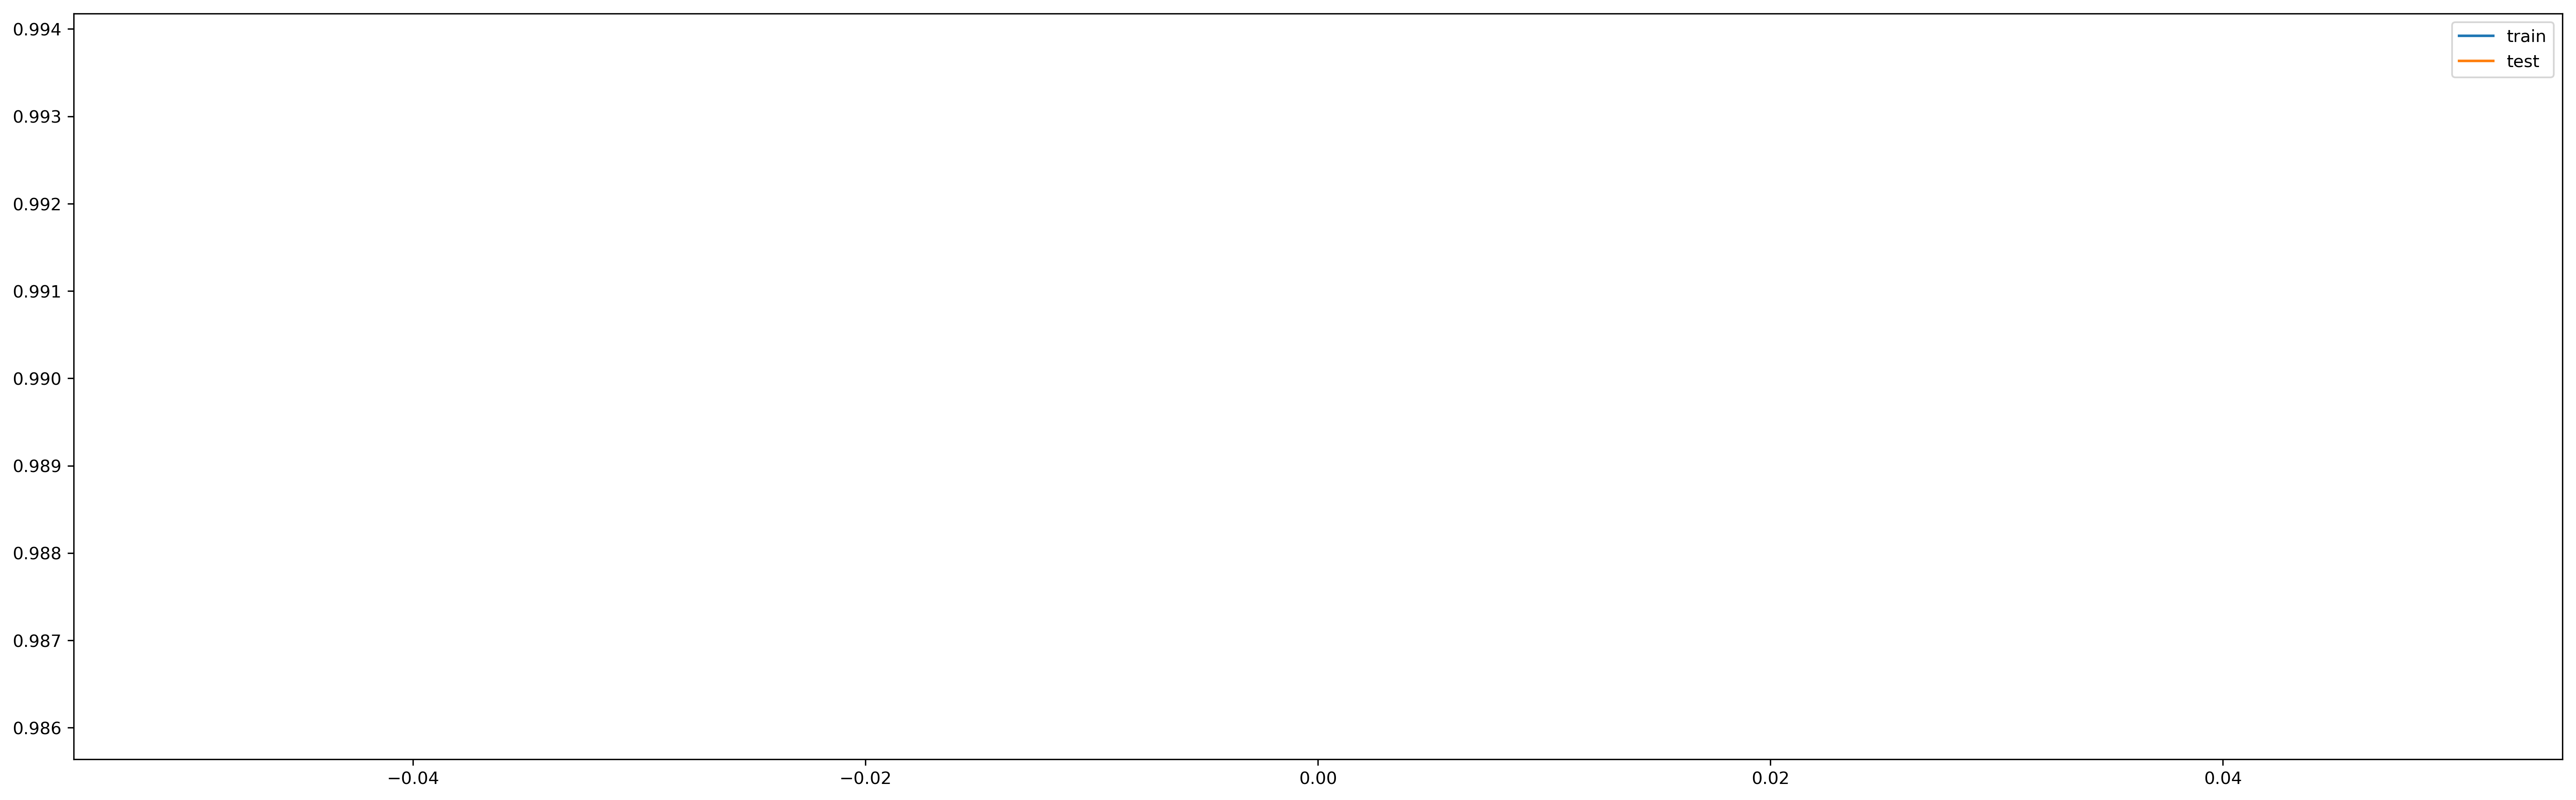

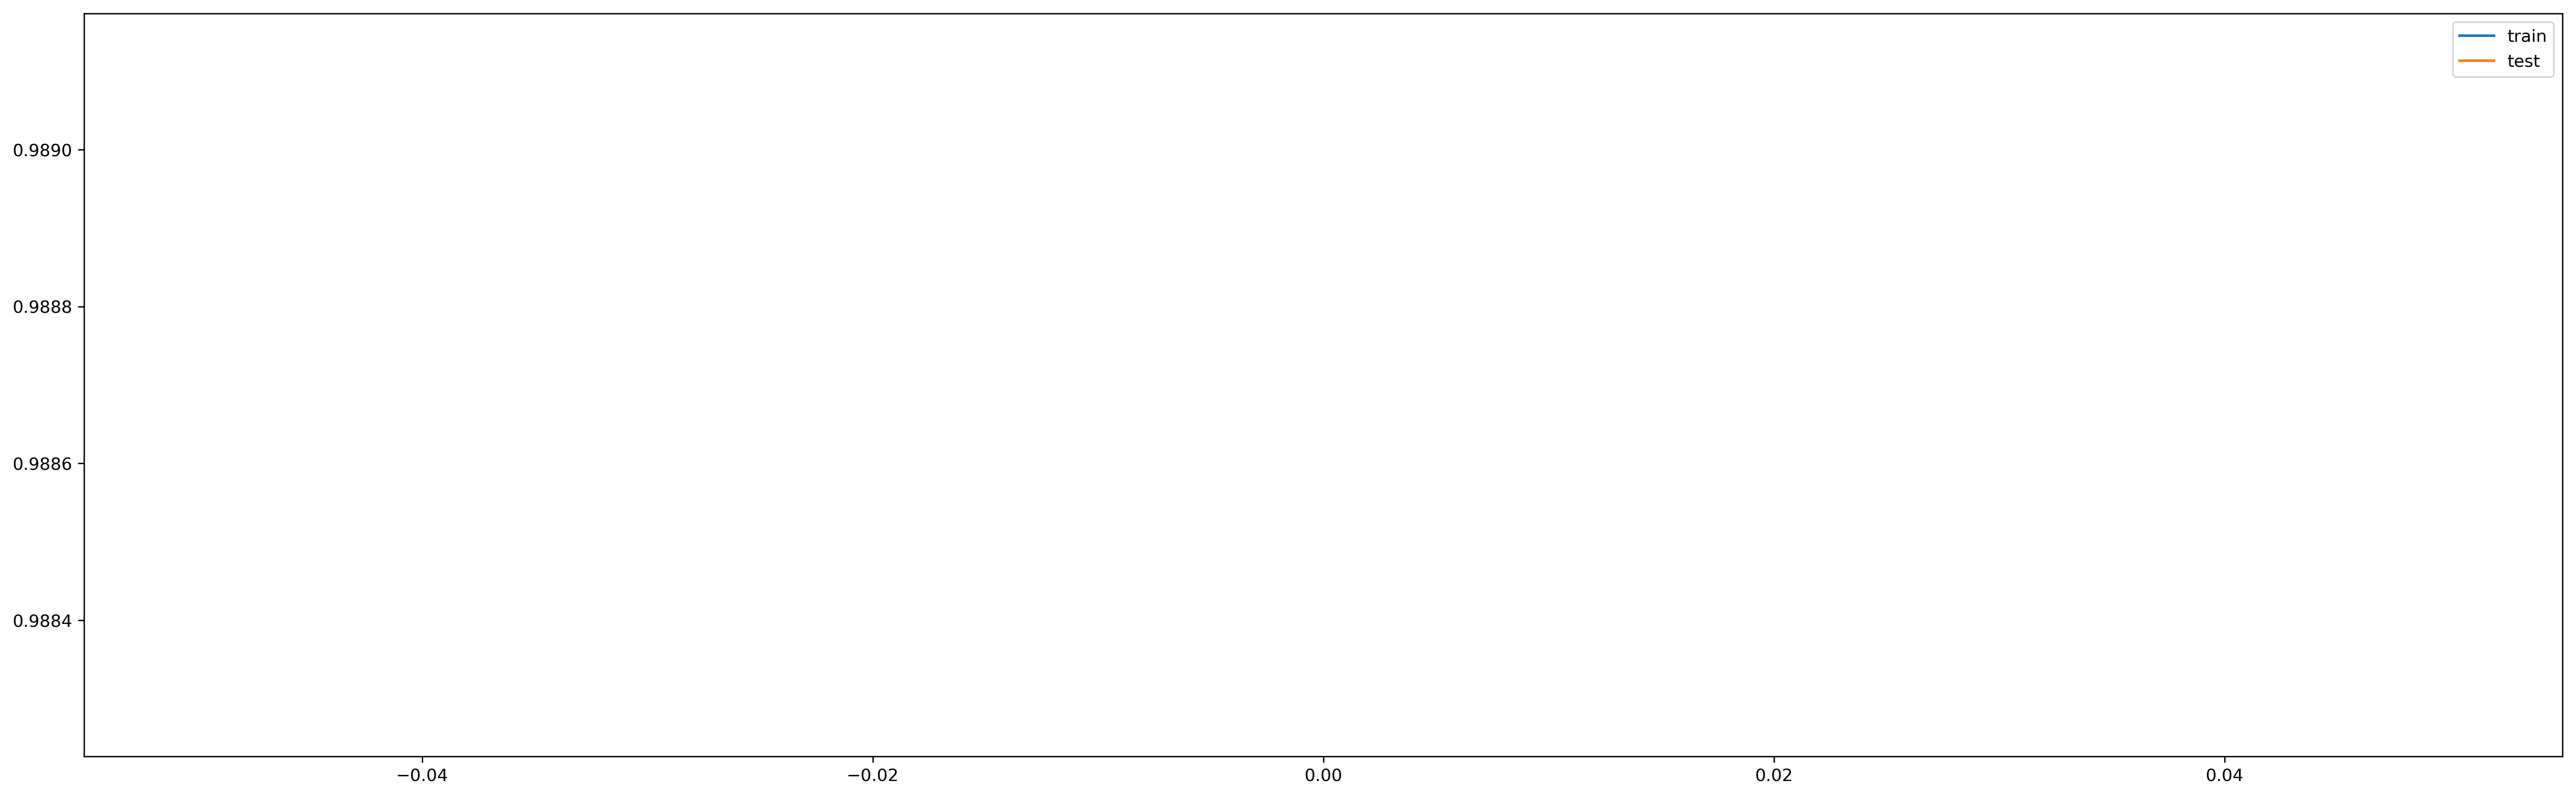

In [136]:
plt.figure(figsize=(26,8),dpi=300)
plt.plot(history_up.history['acc'], label='train')
plt.plot(history_up.history['val_acc'], label='test')
plt.legend()
plt.figure(figsize=(26,8),dpi=300)
plt.plot(history_down.history['acc'], label='train')
plt.plot(history_down.history['val_acc'], label='test')
plt.legend()
plt.show()

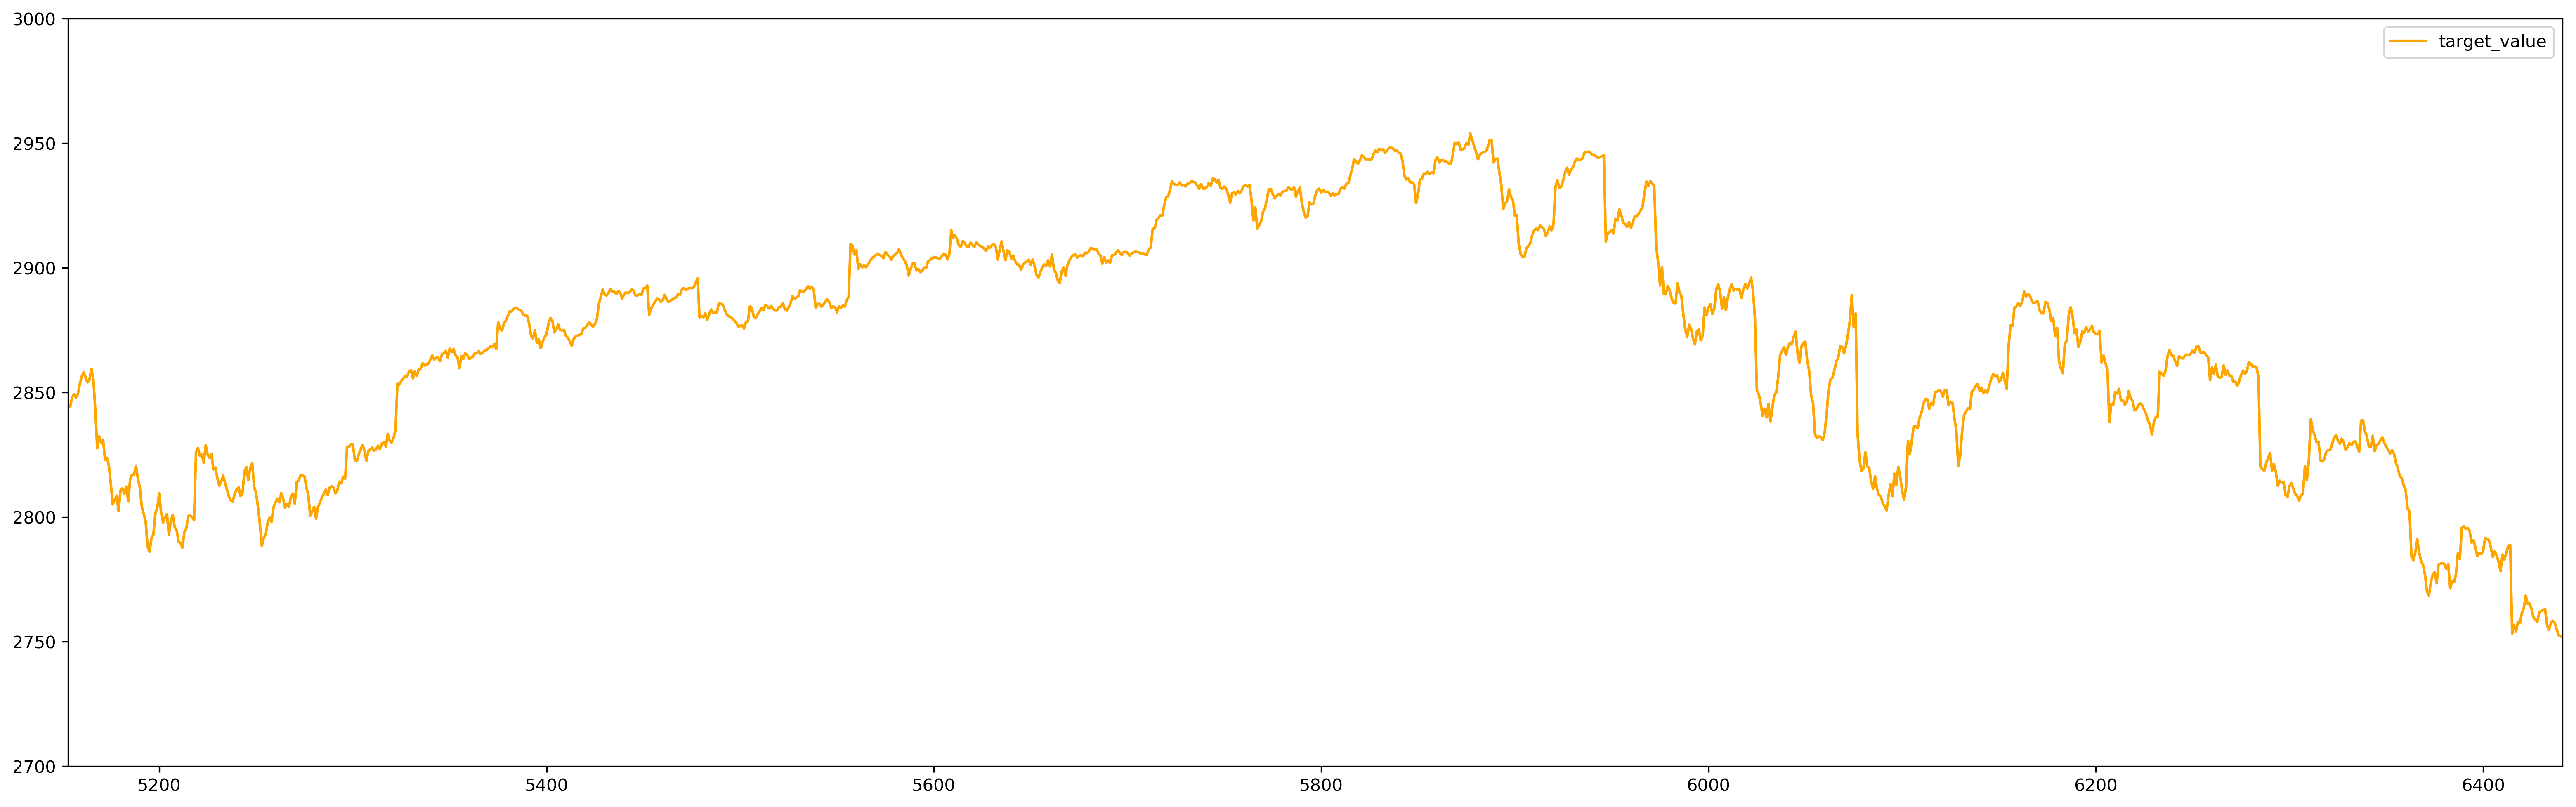

In [98]:
plt.figure(figsize=(26,8),dpi=300)
plt.xlim((len(df_15min)-bloc2,len(df_15min)))
plt.ylim((2700,3000))
plt.plot(df_15min['target_value'],color='orange')
a = -1
for i in range(len(df_15min)-bloc2,len(df_15min)):
    a+=1
    if yhat_up[a] == 1:
        plt.scatter(x=df_15min.index[i],y=df_15min.iloc[i,-1],c='g',marker='o')
    elif yhat_down[a] == 1:
        plt.scatter(x=df_15min.index[i],y=df_15min.iloc[i,-1],c='r',marker='o')
plt.legend()

In [95]:
sum(yhat_up),sum(yhat_down)

(array([4], dtype=int32), array([2], dtype=int32))

In [52]:
# save the model to disk
filename = 'finalized_model_long.sav'
pickle.dump(model_up, open(filename, 'wb'))
filename = 'finalized_model_short.sav'
pickle.dump(model_down, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)